In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import torch

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
import deepwave

import numpy as np
import matplotlib.pyplot as plt

from deepinvhessian import fwi, fwi_lbfgs
from deepinvhessian.utilities import *

In [2]:
set_seed(14)
# https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare data

In [3]:
# Define the model and acquisition parameters
par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'num_shots':30,    'ds':0.3,   'os':0,  'sz':0,
       'num_receivers_per_shot':300,   'dr':0.03,  'orec':0, 'rz':0,
       'nt':5000,  'dt':0.001,  'ot':0,
       'freq': 5, 'num_sources_per_shot':1, 'num_dims':2,
       'num_batches':30,
        'FWI_itr': 100
      }
   
# fs = 1/par['dt'] # sampling frequency
# # declare all the par in local variables
# for k in par:
#     locals()[k] = par[k]
velocity_file = '../data/Marm.bin' 

Text(0.5, 1.0, 'True Model')

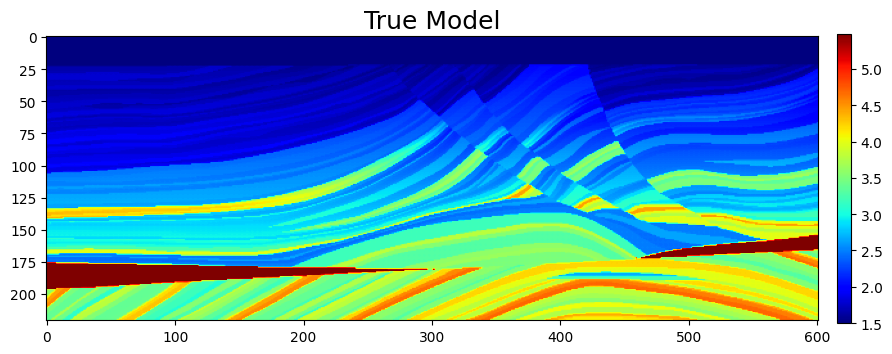

In [4]:
# Load the true model
model_true = (np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']))

plt.figure(figsize=(12,8))
dm_vmin, dm_vmax = np.percentile(model_true, [2,98])
plt.imshow(model_true, vmin=dm_vmin, vmax=dm_vmax, cmap='jet')
plt.colorbar(shrink=0.47, pad=0.02)
plt.title('True Model', fontsize=18)

In [5]:
# function to get water layer mask
def mask(model,value):
    """
    Return a mask for the model (m) using the (value)
    """
    mask = model > value
    mask = mask.astype(int)
    mask[:21] = 0
    return mask

mask = mask(model_true, 1.5)

In [6]:
# Create initial guess model for inversion by smoothing the true model
model_init = gaussian_filter(model_true, sigma=[10,15])
model_init = model_init * mask
model_init[model_init==0] = 1.5 # km/s
model_init = model_init.astype(np.float32)

Text(0.5, 1.0, 'Initial Model')

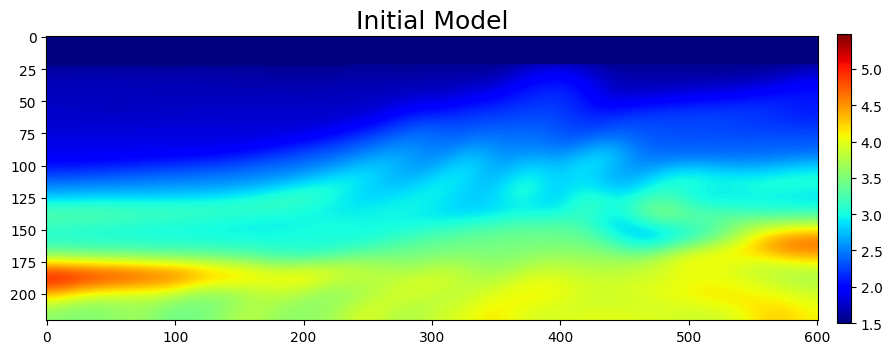

In [7]:
plt.figure(figsize=(12,8))
plt.imshow(model_init, vmin=dm_vmin, vmax=dm_vmax, cmap='jet')
plt.colorbar(shrink=0.47, pad=0.02)
plt.title('Initial Model', fontsize=18)

In [8]:
# Create the source the wavelet
source_wavelet = deepwave.wavelets.ricker(par['freq'], par['nt'], par['dt'], 1/par['freq'])
# Initialize the FWI class
params = fwi.FWIParams(par, torch.tensor(source_wavelet), 1)
# Get the source receiver coordinates
x_s1, x_r1 = params.get_coordinate(1)
# Create a wavelet for every source
source_amplitudes = params.create_wavelet(torch.tensor(source_wavelet))

Text(0.5, 1.0, 'Source wavelet')

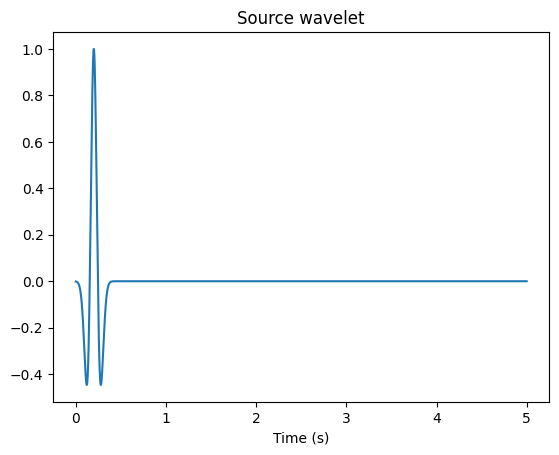

In [9]:
# Visualize the source wavelet
plt.plot(np.arange(0, par['nt'])*par['dt'], source_amplitudes[0,0,:])
plt.xlabel('Time (s)')
plt.title('Source wavelet')

In [10]:
# Simulate the true data
data_true = fwi.forward_modelling(params, torch.tensor(model_true).float(), device)

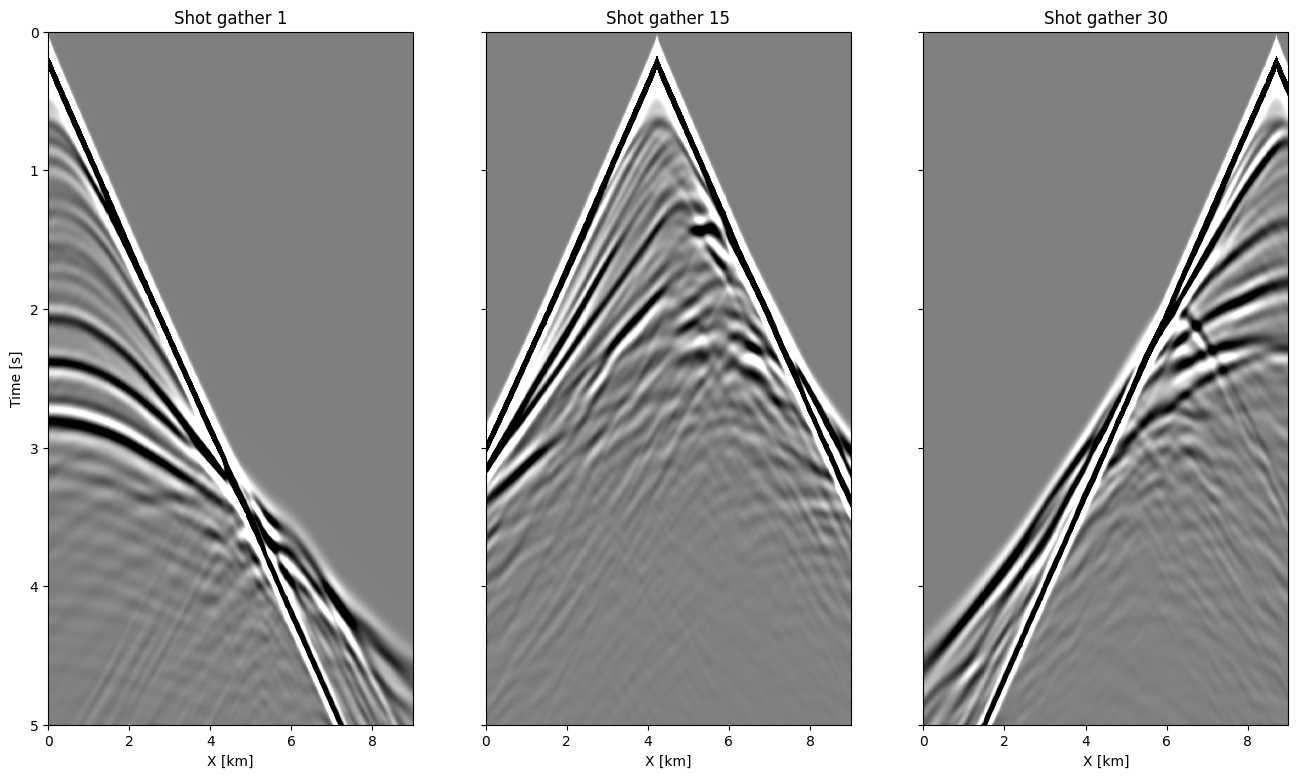

In [11]:
# Visualize the true data
show_3_shots(data_true.cpu(), [0, 14, 29], clip=0.01, extent=(0,int(par['nx']*par['dx']), int(par['nt']*par['dt']), 0), 
        ylim=(int(par['nt']*par['dt']), 0),)

## Run experiment

In [4]:
# Create folder to save the results
exp_name = 'Exp_Marmousi_LBFGS'
if os.path.isdir(exp_name) is False:
    os.makedirs(exp_name)

In [13]:
# Create tensors
model_true = torch.tensor(model_true, dtype=torch.float32)
model_init = torch.tensor(model_init, dtype=torch.float32)
mask = torch.tensor(mask, dtype=torch.float32)

In [14]:
# Initialize the FWI class
fwi = fwi_lbfgs.FWI_LBFGS(data_true, source_amplitudes, params.s_cor, params.r_cor, params.dx, params.dt, 
                          params.num_batches, model_true.shape, mask.to(device), scaling=1., device=device)
# Perform the forward pass
fwi.forward(model_init.detach().cpu().numpy().ravel(), scipy=True)
# Compute the gradient
grad = fwi.grad(model_init.detach().cpu().numpy().ravel(), scipy=True)[-1]
# Compute the gradient scaling
fwi.scaling = (grad * mask.cpu().numpy().ravel()).max()
print(fwi.scaling)

Func
Loss 4.337767578672155e-12
Grad
1.0
8.617080471753653e-15


In [15]:
# Create functions to run FWI with Scipy optimization
fun = lambda x: fwi.forward(x, scipy=True)
grad = lambda x: fwi.grad(x, scipy=True)[-1]
callback = lambda x: fwi.callback(x, model_true, MSSIM, data_residual, nWE)

In [16]:
MSSIM, data_residual, nWE = [], [], []
model0 = model_init.clone().ravel()
# Run FWI using Scipy L-BFGS
nl = minimize(fun, model0, jac=grad,
              method='L-BFGS-B', 
              callback=callback,
              options=dict(maxiter=50,),
             )
MSSIM = np.array(MSSIM)
nWE = np.array(nWE)
data_residual = np.array(data_residual)

Func
Loss 503.3917917897058
Grad
8.617080471753653e-15
Func
Loss 448.67162784607837
Grad
8.617080471753653e-15
Func
Loss 448.67162784607837
Func
Loss 503.52696585841323
Grad
8.617080471753653e-15
Func
Loss 280.785952733113
Grad
8.617080471753653e-15
Func
Loss 280.785952733113
Func
Loss 248.05646610774352
Grad
8.617080471753653e-15
Func
Loss 248.05646610774352
Func
Loss 228.59132078991843
Grad
8.617080471753653e-15
Func
Loss 228.59132078991843
Func
Loss 185.046957546421
Grad
8.617080471753653e-15
Func
Loss 185.046957546421
Func
Loss 166.8745778759262
Grad
8.617080471753653e-15
Func
Loss 166.8745778759262
Func
Loss 151.7305955135491
Grad
8.617080471753653e-15
Func
Loss 151.7305955135491
Func
Loss 131.77629692292132
Grad
8.617080471753653e-15
Func
Loss 131.77629692292132
Func
Loss 116.5810519014911
Grad
8.617080471753653e-15
Func
Loss 116.5810519014911
Func
Loss 104.61921530900686
Grad
8.617080471753653e-15
Func
Loss 104.61921530900686
Func
Loss 93.476950981166
Grad
8.617080471753653e-15


## Plot and save results

In [17]:
# Include the first data residual from the forward pass
first_res = 4.337767578672155e-12 / par['num_shots']
# Descale the data residual
data_res = data_residual * fwi.scaling / par['num_shots']
data_res = np.concatenate([np.array([first_res]), data_res], axis=0)

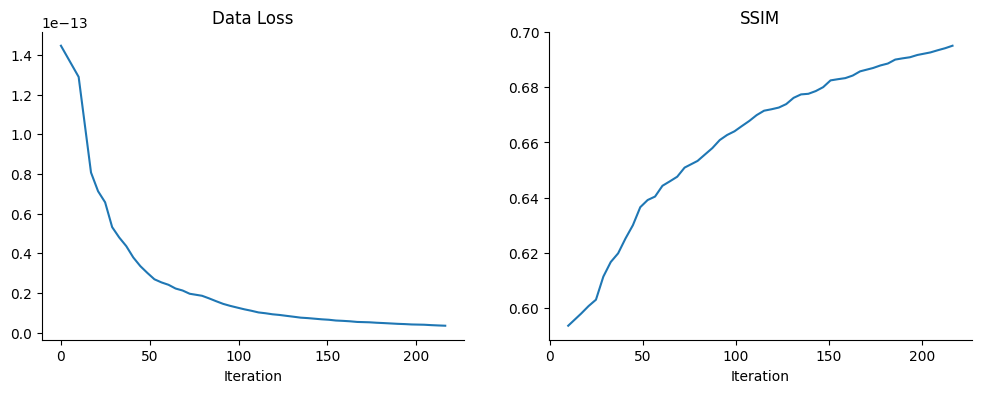

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(np.concatenate([[0], nWE/params.num_shots]), data_res)
axs[0].set_title('Data Loss')
axs[0].set_xlabel('Iteration')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].plot(nWE/params.num_shots, MSSIM)
axs[1].set_title('SSIM')
axs[1].set_xlabel('Iteration')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.savefig(f'{exp_name}/losses.png',  bbox_inches='tight', dpi=300)

In [20]:
np.savez(f'{exp_name}/results', data_loss=np.array(data_res),
                               mssim=np.array(MSSIM),
                                nWE=np.array(nWE/params.num_shots))

In [21]:
# Save the inverted model
update = nl.x.reshape(par['nz'], par['nx'])
np.save(f'{exp_name}/update', update)

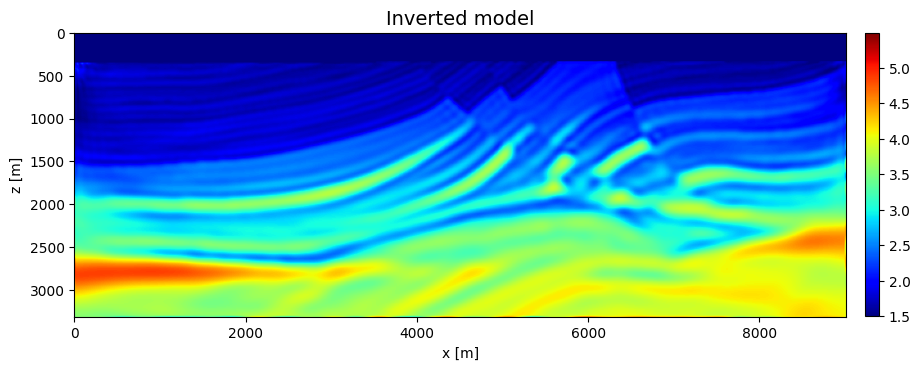

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
im1 = axs.imshow(update, cmap='jet', vmin=dm_vmin, vmax=dm_vmax, extent=(0, par['nx']*par['dx']*1000, par['nz']*par['dx']*1000, 0))
axs.set_title(r'Inverted model', fontsize=14)
axs.set_xlabel(r'x [m]')
axs.set_ylabel(r'z [m]')
fig.colorbar(im1, ax=axs, shrink=0.46, pad=0.02)
plt.savefig(f'{exp_name}/model_updated', bbox_inches='tight', dpi=300)